In [ ]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import datetime

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!ls 'drive/My Drive'

Mounted at /content/drive
 5-tarfi.rar				    photo-5.pdf
 Active_maghale.ipynb			    photo-6.pdf
 affain.m				    photo-7.pdf
'Colab Notebooks'			    photo-8.pdf
'Copy of Active.ipynb'			   'photo-91(10).pdf'
'Copy of Copy of Untitled1.ipynb'	   'photo-92(11).pdf'
 datamini				    photo-9.pdf
 datamini2				   'pp (1).m'
 demo.ipynb				    pp.m
'dr.niazmardi NEURAL NETWORK PROJECT.rar'   README.md
'dr sarajian.rar'			    RKH.rar
'Getting started.pdf'			   'roshan asigment.rar'
 kernels.py				    rrr.rar
 LICENSE				   'S4&5.rar'
 maghale				    sajjadroshan97100186.rar
 matdataset				    segnetactive.ipynb
 mini					   'Single Time AL.rar'
 paiannameh				    soltani
 pdn					    svm.py
 photo-1.pdf				    Untitled3.m
 photo-2.pdf				    اسلاید-45-24.pdf
 photo-3.pdf				   'مقاله اول .pdf'


In [ ]:
# Parameters
WINDOW_SIZE = (64,64) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
FOLDER = "/content/drive/My Drive//datamini/" # Replace with your /path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 10 # Number of samples in a mini-batch

LABELS = ["buildings", "trees",  "clutter","Low vegetation","Cars","Undefined"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'Vaihingen'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    DATA_FOLDER = MAIN_FOLDER + 'Y_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER
    DATA_FOLDER = MAIN_FOLDER + 'top/image{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'gt/image{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'gt/noBoundary{}.tif'
    Poll_FOLDER =  MAIN_FOLDER + 'POOL/POOL{}.tif'

In [ ]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)
invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
#img = io.imread(r'e:/ISPRS_dataset/Vaihingen/top/top_mosaic_09cm_area11.tif')
#fig = plt.figure()
#fig.add_subplot(121)
#plt.imshow(img)

# We load the ground truth
#gt = io.imread(r'e:/ISPRS_dataset/Vaihingen/gts_for_participants/top_mosaic_09cm_area11.tif')
#fig.add_subplot(122)
#plt.imshow(gt)
#plt.show()

# We also check that we can convert the ground truth into an array format
#array_gt = convert_from_color(gt)
#print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

In [ ]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]

def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))

    print("Confusion matrix :")
    print(cm)

    print("---")

    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))

    print("---")

    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")

    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [ ]:
# Dataset class

class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()

        self.augmentation = augmentation
        self.cache = cache

        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))

        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}


    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000

    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True

        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))

        return tuple(results)

    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)

        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data

        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else:
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]

        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

In [ ]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)

    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)

        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)

        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)

        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)

        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)

        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)

        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)

        self.apply(self.weight_init)

    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)

        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)

        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)

        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)

        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)

        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))

        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))

        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))

        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))

        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x

In [ ]:
# instantiate the network
net = SegNet()

In [ ]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))

try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

In [ ]:
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom

In [ ]:
# Load the datasets
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["_".join(f.split('_')[3:5]) for f in all_files]
elif DATASET == 'Vaihingen':
    #all_ids =
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
#Random tile numbers for train/test split
#train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
#test_ids = list(set(all_ids) - set(train_ids))

# Exemple of a train/test split on Vaihingen :
#train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
test_ids = ['a1']
train_ids = []
for i in range(1,5,1):
   train_ids = train_ids +[str(i)]
pool_ids = [ ]
for i in range(1,73,1):
  pool_ids = pool_ids +[str(i)]
print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)
print("Tiles for pooling data :",pool_ids)
#train_set = ISPRS_dataset(train_ids, cache=CACHE)
#train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['1', '2', '3', '4']
Tiles for testing :  ['a1']
Tiles for pooling data : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']


In [ ]:
#mini dataset
train_ids = ['31', '24', '45','44','52','62','7','15','33','25','11','22','55','63','13','1','2']
test_ids = ['a1']
pool_ids = list(set(pool_ids) - set(train_ids))
print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)
print("Tiles for pooling data :",pool_ids)
train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['31', '24', '45', '44', '52', '62', '7', '15', '33', '25', '11', '22', '55', '63', '13', '1', '2']
Tiles for testing :  ['a1']
Tiles for pooling data : ['18', '39', '58', '60', '42', '67', '27', '59', '30', '53', '70', '51', '29', '4', '9', '14', '66', '32', '37', '38', '54', '50', '36', '43', '10', '61', '35', '23', '3', '72', '47', '5', '40', '68', '48', '71', '34', '56', '8', '57', '20', '28', '17', '46', '16', '64', '26', '12', '21', '49', '69', '6', '41', '65', '19']


In [ ]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

In [ ]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()

            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)

            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)
        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [ ]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0

    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()

            losses[iter_] = loss.data
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])

            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data, accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1

            del(data, target, loss)

        if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './segnet_final')

Train (epoch 1/10) [500/1000 (50%)]	Loss: 0.654280	Accuracy: 85.9375


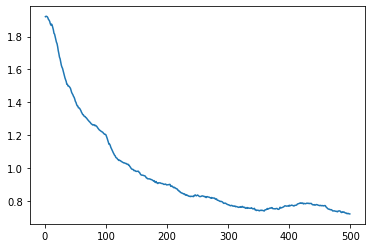

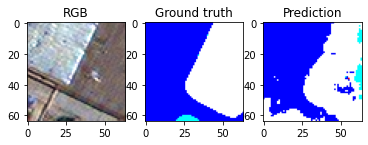

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
#_______________________________________normal segenet
a = datetime.datetime.now()
train(net, optimizer,10, scheduler)
b = datetime.datetime.now();
d = b - a;d=int(d.total_seconds())
print(d)

In [ ]:
net.load_state_dict(torch.load('./segnet_final'))

In [ ]:
 test_ids = ['a1']

In [ ]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32)

Confusion matrix :
[[366604  29071  13895      0      0   2452]
 [ 45470 464586   7503      0      0   1812]
 [  6646   4768 240763      0      0     93]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]
 [  4378   3131    555      0      0  26839]]
---
1218566 pixels processed
Total accuracy : 90.17090580239396%
---
F1Score :
buildings: 0.8779672382412108
trees: 0.9101257974370351
clutter: 0.9350273599670671
Low vegetation: nan
Cars: nan
Undefined: 0.8120849029486074
---
Kappa: 0.8514810040426962


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


Confusion matrix :
[[366604  29071  13895      0      0   2452]
 [ 45470 464586   7503      0      0   1812]
 [  6646   4768 240763      0      0     93]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]
 [  4378   3131    555      0      0  26839]]
---
1218566 pixels processed
Total accuracy : 90.17090580239396%
---
F1Score :
buildings: 0.8779672382412108
trees: 0.9101257974370351
clutter: 0.9350273599670671
Low vegetation: nan
Cars: nan
Undefined: 0.8120849029486074
---
Kappa: 0.8514810040426962


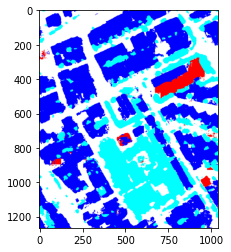

In [ ]:
for p, id_ in zip(all_preds, pool_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./activesegnet_{}.tif'.format(id_), img)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def active_learner(net,pool_ids,train_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    train(net, optimizer, 1, scheduler)
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in pool_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in pool_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in pool_ids)
    all_preds = []
    all_gts = []
    s_list =[]
    k = 0
    # Switch the network to inference mode
    net.eval()
    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(pool_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))
        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))

            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)

            # Do the inference
            outs = net(image_patches)
            o3 = outs
            #print(o1)
            #o2 = torch.round(o1)
            #o3 = torch.abs(o1 - o2)
            s = float(torch.sum(o3))
            s_list = s_list + [s]
            print('sum=',s)
            print(s_list)
            k += 1
            print(k)

        #s = np.array(s_list);pool_ids = np.array(pool_ids)
        #inds = s.argsort()
        #pool_ids = np.array(pool_ids)
        #pool_ids = pool_ids[inds]
        #print("kham");print(pool_ids)
        #pool_ids = pool_ids.tolist()
        #trai_ids = train_ids + list(pool_ids[0])
        #del pool_ids[0]
        #acc, all_preds, all_gts = test(net, pool_ids, all=True, stride=32)
        #if pool_ids == [] :
        #   print('pool is empty')
        #   a = 2
        #else:
        #   a = 1
        #print(trai_ids)
        #print(pool_ids)
        #return(trai_ids,pool_ids,a)
        print(s_list)
        return(k)

In [ ]:
k = active_learner(net,pool_ids, train_ids, all=True, stride=32)

In [ ]:
#sorting s_list
s = np.array(s_list);pool_ids = np.array(pool_ids)
inds = s.argsort()
pool_ids = pool_ids[inds]
pool_ids = pool_ids.tolist()
train_ids = train_ids + list(pool_ids[0])
del pool_ids[0]
if pool_ids == []:
 print('pool is empty')
 a = 2
a = 1;
print(train_ids)
print(pool_ids)

In [ ]:
pool_ids = []
for i in range(16,2399,1):
    pool_ids = pool_ids +[str(i)]
del pool_ids[1]
print(pool_ids)

In [ ]:
print(k)

In [ ]:
print(pool_ids)

In [ ]:
def active(net, pool_ids,train_ids,test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    train(net, optimizer, 10, scheduler)
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in pool_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in pool_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in pool_ids)
    all_preds = []
    all_gts = []
    s_list = []
    s_list2 =[]
    k = 0
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(pool_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)

            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)

            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            s = 0;su = 0;
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                for vi in range(0,64):
                    for vj in range(0,64):
                       s = s + float(np.max(out[:,vi,vj]))
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            s_list = s_list + [s]
            del(outs)
            su = [np.sum(s_list)]
            s_list =[]
        s_list2 = s_list2 + su
        pred = np.argmax(pred, axis=-1)
        # Display the result
        clear_output()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        s = np.array(s_list2);
        inds = s.argsort()
        poo_ids = np.array(pool_ids)
        pooll_ids = poo_ids[inds[::-1]]
        pooll_ids = pooll_ids.tolist()
        trai_ids = train_ids + pooll_ids[0:2]
        del pooll_ids[0:2]
    acc, all_predss, all_gtss = test(net,["a1"], all=True, stride=32)
    a = 1
    accmax, all_predss, all_gtss = test(net,["a1"], all=True, stride=32)
    if pooll_ids == [] :
      print('pool is empty or you reached at accuracy goal')
      a = 2
    else:
      a = 1
    if all:
        return s_list2,pooll_ids,trai_ids,a,acc
    else:
        return pooll_ids,trai_ids,a,acc

In [ ]:
########random sampling
lrs = [];accr=[];tr = [];k=1
aa = datetime.datetime.now();
for i in range(0,11):
  train_set = ISPRS_dataset(train_ids, cache=CACHE)
  train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)
  train(net, optimizer,10, scheduler)
  lrs = lrs + [len(train_ids)]
  id = np.random.randint(low=0, high=len(pool_ids), size=1)
  d = pool_ids[int(id)]
  train_ids = train_ids + [d]
  pool_ids = np.delete(pool_ids,[int(id)], axis=0)
  id = np.random.randint(low=0, high=len(pool_ids), size=1)
  d = pool_ids[int(id)]
  train_ids = train_ids + [d]
  acci, all_predss, all_gtss = test(net,["a1"], all=True, stride=32)
  b = datetime.datetime.now();
  dt = b - aa;dt=dt.total_seconds();tr = tr + [dt]
  if acci >=85.6 and k==1:
    reachtime = dt;reaca=acci;rl=len(train_ids);k=2
  accr=accr+[acci]

Confusion matrix :
[[332953  52644  21001      0      0   5424]
 [ 26049 486120   7108      0      0     94]
 [  3588   4868 243712      0      0    102]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]
 [  4775   9110   1019      0      0  19999]]
---
1218566 pixels processed
Total accuracy : 88.8572305480376%
---
F1Score :
buildings: 0.8543971095232535
trees: 0.9068447076007846
clutter: 0.9282321799242064
Low vegetation: nan
Cars: nan
Undefined: 0.6608836456164701
---
Kappa: 0.8306002541225777
Confusion matrix :
[[332953  52644  21001      0      0   5424]
 [ 26049 486120   7108      0      0     94]
 [  3588   4868 243712      0      0    102]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]
 [  4775   9110   1019      0      0  19999]]
---
1218566 pixels processed
Total accuracy : 88.8572305480376%
---
F1Score :
buildings: 0.8543971095232535
trees: 0.9068447076007846
clutter: 0.9282321799242064
Low ve

In [ ]:
#active learning
las =[];acca=[];ta = [];k=1
aa = datetime.datetime.now();
for i in range(1,2):
   las = las + [len(train_ids)-14]
   train_set = ISPRS_dataset(train_ids, cache=CACHE)
   train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)
   s_list2,pool_ids,train_ids,a,acc= active(net, pool_ids,train_ids,test_ids, all=True, stride=32)
   b = datetime.datetime.now();
   dt = b - aa;dt=dt.total_seconds();ta = ta + [dt]
   acca=acca+[acc]
   if acc >=85.6 and k==1:
     rt = dt;rca=acc;rla=len(train_ids)-14;k=2

Confusion matrix :
[[366604  29071  13895      0      0   2452]
 [ 45470 464586   7503      0      0   1812]
 [  6646   4768 240763      0      0     93]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]
 [  4378   3131    555      0      0  26839]]
---
1218566 pixels processed
Total accuracy : 90.17090580239396%
---
F1Score :
buildings: 0.8779672382412108
trees: 0.9101257974370351
clutter: 0.9350273599670671
Low vegetation: nan
Cars: nan
Undefined: 0.8120849029486074
---
Kappa: 0.8514810040426962
Confusion matrix :
[[366604  29071  13895      0      0   2452]
 [ 45470 464586   7503      0      0   1812]
 [  6646   4768 240763      0      0     93]
 [     0      0      0      0      0      0]
 [     0      0      0      0      0      0]
 [  4378   3131    555      0      0  26839]]
---
1218566 pixels processed
Total accuracy : 90.17090580239396%
---
F1Score :
buildings: 0.8779672382412108
trees: 0.9101257974370351
clutter: 0.9350273599670671
Low 

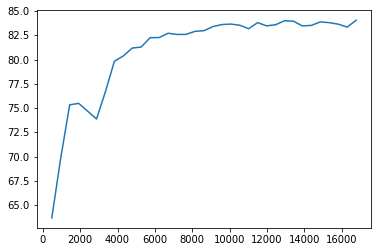

In [ ]:
reach_random_time=12932.96457412932
random_reach_lengh=60
len_random=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74]
acc_random = [63.67697769345279, 69.87212838697288, 75.34109765084534, 75.49209480651848, 74.69156369043613, 73.87921540564894, 76.70983762881944, 79.83597113328288, 80.38333582259803, 81.1965868077724, 81.30146418002799, 82.26718946696363, 82.27908869934004, 82.72551507263455, 82.59741368132707, 82.60808195863005, 82.91787231877468, 82.98959596771942, 83.41041847548675, 83.61902432859607, 83.67146301472386, 83.54836750738163, 83.19311387319193, 83.81852111416205, 83.48501435293615, 83.59719539196071, 84.01325820677746, 83.96369174915434, 83.48009053264246, 83.53277540978495, 83.89213222755271, 83.81655158604458, 83.66022029171994, 83.35871836240302, 84.06446593783184]
time_random = [480.572689, 959.986156, 1438.914122, 1916.768547, 2396.086512, 2875.179184, 3353.226576, 3830.970792, 4308.868552, 4786.84054, 5265.325587, 5744.269746, 6223.435402, 6703.275437, 7183.9955, 7664.12458, 8143.846574, 8623.528484, 9102.27577, 9581.570454, 10060.800618, 10539.036597, 11016.854623, 11495.594017, 11974.392654, 12453.011461, 12932.964574, 13413.220337, 13892.299196, 14370.575681, 14850.001179, 15329.247277, 15809.336344, 16288.864955, 16768.031599]
#plt.plot(las ,acca)
plt.plot(time_random,acc_random)

In [ ]:
print(ta)
len_active = [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72]
active_acc = [77.863652850974, 67.79657400583964, 70.61414810523189, 70.73510995711352, 70.84039764772692, 71.95884342743848, 71.45899360395744, 72.638823009997, 72.34249109198845, 75.48536558545044, 76.0904210358733, 76.77630920278425, 75.63783988721168, 74.82409652000794, 74.36125741240113, 75.35102735510428, 75.04222175901839, 77.95228161626042, 79.90391985333581, 79.50197199002761, 78.87180505610692, 79.2311618738747, 79.68981573423187, 80.08683977724637, 80.54787348407882, 80.30119008736499, 80.1756326698759, 81.19018584139062, 81.1914988601356, 81.44868640680932, 80.6154939494455, 81.01686736705274, 80.32375759704439, 80.65324323836379]
time_s = [571.26524, 1074.63331, 1576.374362, 2078.896998, 2582.250608, 3085.418245, 3588.096238, 4090.197681, 4592.365541, 5094.504981, 5596.739073, 6100.056176, 6603.511184, 7106.104991, 7607.892765, 8109.941087, 8611.481627, 9113.222116, 9614.880949, 10116.058169, 10618.872684, 11118.516203, 11618.539916, 12118.245685, 12618.875586, 13118.685419, 13617.595859, 14116.52173, 14616.748874, 15116.440688, 15616.157762, 16116.089706, 16615.897442, 17114.817441]

[571.26524, 1074.63331, 1576.374362, 2078.896998, 2582.250608, 3085.418245, 3588.096238, 4090.197681, 4592.365541, 5094.504981, 5596.739073, 6100.056176, 6603.511184, 7106.104991, 7607.892765, 8109.941087, 8611.481627, 9113.222116, 9614.880949, 10116.058169, 10618.872684, 11118.516203, 11618.539916, 12118.245685, 12618.875586, 13118.685419, 13617.595859, 14116.52173, 14616.748874, 15116.440688, 15616.157762, 16116.089706, 16615.897442, 17114.817441]


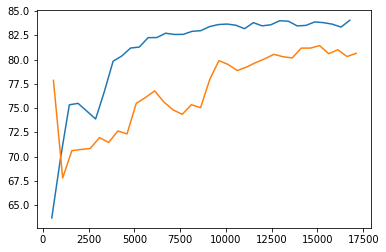

In [ ]:
plt.plot(time_random,acc_random)
plt.plot(time_s ,active_acc)

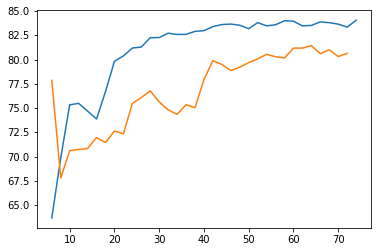

In [ ]:
plt.plot(len_random,acc_random)
plt.plot(len_active,active_acc)

In [ ]:
#128*128random
x_datar=[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
accrr = [79.18052858852126, 83.58907108847612, 84.51598025876316, 85.63196412832788, 86.33163899206116, 86.4534214806584, 85.35623019188127, 87.6231570550959, 88.13145943674778, 88.66085218199096, 88.8572305480376]
t_random = [637.226078, 1280.496477, 1924.700874, 2568.764701, 3214.014385, 3859.159948, 4503.796284, 5148.127056, 5792.639466, 6437.634755, 7081.053534]
x_reach = 11
time_reach = 2568.764701
acc_rar = 85.63196412832788

In [ ]:
#print(las)
X_active = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21,23]
#print(acca)
acc_active = [76.4830464660921, 88.12686387114033, 88.82752349893235, 89.13739592274854, 89.33418460715299, 90.30376688665201, 90.26790506217964, 89.96894710668113, 89.90969713581373, 89.93636782907122,90.17090580239396]
ta = [737.529452, 1433.647845, 2128.984151, 2823.482059, 3517.056774, 4209.709876, 4904.717737, 5600.22007, 6292.104946, 6981.686136,7660.2234657]
#print(rt)
r_time = 1433.647845
ac = 88.12686387114033
r_reach=5

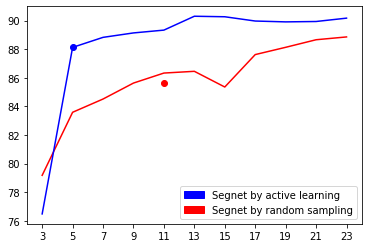

In [ ]:
plt.figure()
plt.plot(x_datar,accrr,'r')
plt.plot(X_active,acc_active,'b')
line5 = mpatches.Patch( label='Segnet by active learning',color='b')
line6 = mpatches.Patch( label='Segnet by random sampling',color='r')
plt.legend(handles=[line5,line6],loc='lower right')
plt.xticks(np.arange(min(x_datar), max(x_datar)+1, 2))
plt.scatter(x_reach,acc_rar,c="r")
plt.scatter(r_reach,ac,c="b")
plt.savefig('xofsegnet.tif')

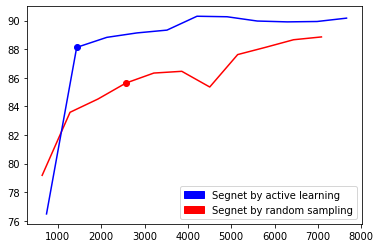

In [ ]:
plt.figure()
plt.plot(t_random,accrr,'r')
plt.plot(ta,acc_active,'b')
line5 = mpatches.Patch( label='Segnet by active learning',color='b')
line6 = mpatches.Patch( label='Segnet by random sampling',color='r')
plt.legend(handles=[line5,line6],loc='lower right')
plt.scatter(time_reach,acc_rar,c="r")
plt.scatter(r_time,ac,c="b")
plt.savefig('tofsegnet.tif')